In [74]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pandas as pd

# Load results from pipeline_results.json
with open('../core/pipeline_results.json', 'r') as f:
    results = json.load(f)

print("Results loaded successfully!")

Results loaded successfully!


In [75]:
# Extract data for confidence plots
steering_scores = results['tatqa_evaluation']['steering_scores']
true_labels = results['tatqa_evaluation']['true_labels']
steering_predictions = results['tatqa_evaluation']['steering_predictions']
optimal_threshold = results['calibration']['optimal_threshold']

# Separate scores by true labels
correct_scores = [score for score, label in zip(steering_scores, true_labels) if label == 0]
halluc_scores = [score for score, label in zip(steering_scores, true_labels) if label == 1]

print(f"Total samples: {len(steering_scores)}")
print(f"Correct samples: {len(correct_scores)}")
print(f"Hallucination samples: {len(halluc_scores)}")
print(f"Optimal threshold: {optimal_threshold:.3f}")

Total samples: 100
Correct samples: 70
Hallucination samples: 30
Optimal threshold: 13.147


/scratch/9613420.1.csgpu/ipykernel_4086745/2377298411.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1].boxplot(data_to_plot, labels=labels, patch_artist=True)


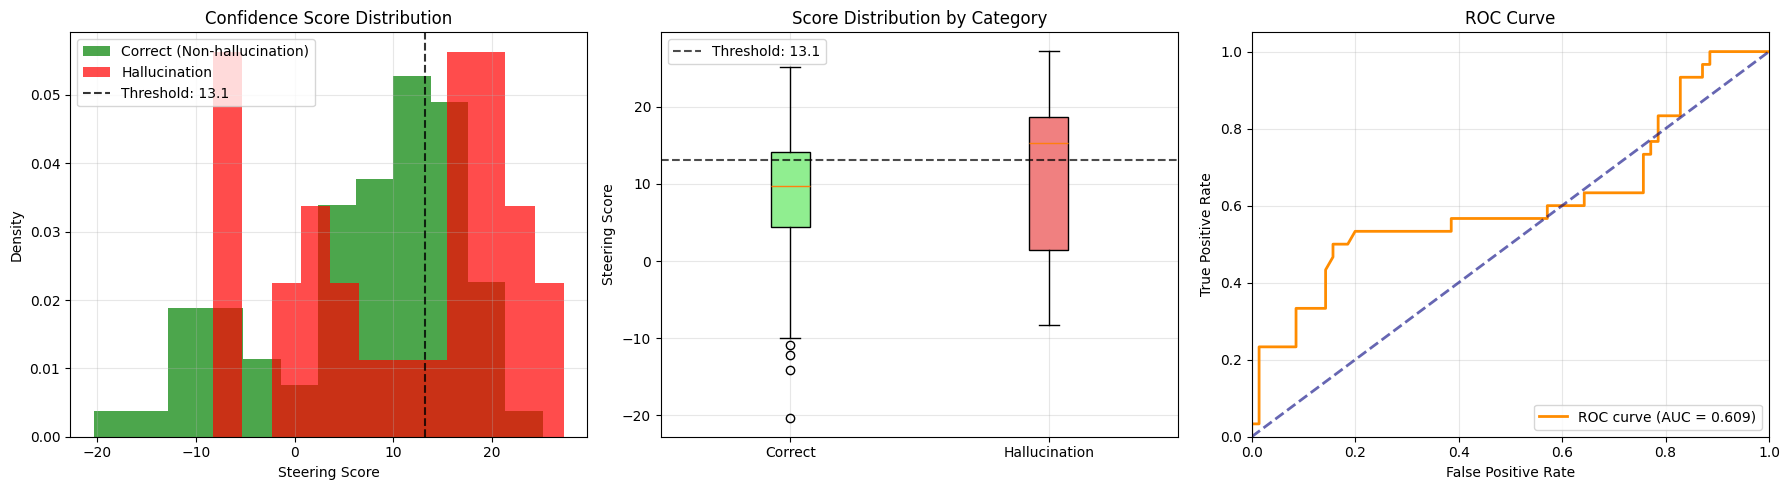

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Create a 1-row, 3-column layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogram: Confidence Score Distribution
axes[0].hist(correct_scores, alpha=0.7, bins=12, label='Correct (Non-hallucination)', color='green', density=True)
axes[0].hist(halluc_scores, alpha=0.7, bins=12, label='Hallucination', color='red', density=True)
axes[0].axvline(optimal_threshold, color='black', linestyle='--', alpha=0.8, label=f'Threshold: {optimal_threshold:.1f}')
axes[0].set_xlabel('Steering Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Confidence Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Box Plot: Score Distribution
data_to_plot = [correct_scores, halluc_scores]
labels = ['Correct', 'Hallucination']
box_plot = axes[1].boxplot(data_to_plot, labels=labels, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightgreen')
box_plot['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(optimal_threshold, color='black', linestyle='--', alpha=0.7, label=f'Threshold: {optimal_threshold:.1f}')
axes[1].set_ylabel('Steering Score')
axes[1].set_title('Score Distribution by Category')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. ROC Curve
fpr, tpr, _ = roc_curve(true_labels, steering_scores)
roc_auc = auc(fpr, tpr)
axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6)
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve')
axes[2].legend(loc="lower right")
axes[2].grid(True, alpha=0.3)

# Final layout
plt.tight_layout()
plt.show()

In [77]:
# Print summary statistics
print("=== Confidence Scoring Results Summary ===")
print(f"Total samples: {results['tatqa_evaluation']['total_samples']}")
print(f"Model accuracy: {results['tatqa_evaluation']['model_accuracy']:.3f}")
print(f"Hallucination rate: {results['tatqa_evaluation']['hallucination_rate']:.3f}")
print(f"Detection accuracy: {results['tatqa_evaluation']['detection_accuracy']:.3f}")
print(f"Detection precision: {results['tatqa_evaluation']['detection_precision']:.3f}")
print(f"Detection recall: {results['tatqa_evaluation']['detection_recall']:.3f}")
print(f"Detection F1: {results['tatqa_evaluation']['detection_f1']:.3f}")
print(f"ROC AUC: {results['calibration']['roc_auc']:.3f}")
print(f"Optimal threshold: {results['calibration']['optimal_threshold']:.3f}")
print(f"Mean correct projection: {results['calibration']['mean_correct_projection']:.3f}")
print(f"Mean hallucination projection: {results['calibration']['mean_halluc_projection']:.3f}")

=== Confidence Scoring Results Summary ===
Total samples: 100
Model accuracy: 0.700
Hallucination rate: 0.300
Detection accuracy: 0.630
Detection precision: 0.410
Detection recall: 0.533
Detection F1: 0.464
ROC AUC: 0.637
Optimal threshold: 13.147
Mean correct projection: 6.464
Mean hallucination projection: 10.209


In [78]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'core'))
from main_evaluation import load_tatqa_samples_split
N_SAMPLES=50
_, tat_test  = load_tatqa_samples_split(N_SAMPLES)


Loaded and split TAT-QA data: 50 validation, 50 test samples


In [79]:
tatqa = results['tatqa_evaluation']

# Construct the full dataframe
df = pd.DataFrame({
    "Question": tatqa['questions'],
    "Gold Answer": tatqa['ground_truth_answers'],
    "Model Answer": tatqa['model_responses'],
    "Hallucination Score": tatqa['steering_scores'],
    "Steering Prediction": tatqa['steering_predictions'],
    "True Label": tatqa['true_labels']
})


### False positives

In [80]:
df[(df['Steering Prediction'] == 1) & (df['True Label'] == 0)]

,Question,Gold Answer,Model Answer,Hallucination Score,Steering Prediction,True Label
2,What was the other accounts receivable in 2019?,"['8,390']",Answer: 8390,16.7500,1,0
8,What was the animal feed waste avoided in FY19?,"['4,454']",Answer: 4454,18.1250,1,0
11,What is the percentage growth in revenue from ...,['19'],Answer: 19.0,15.4375,1,0
14,What is the cost of revenue percentage for fis...,['22'],Answer: 22,16.7500,1,0
22,What is the valuation allowance in 2019?,"['2,518']",Answer: 2518,19.6250,1,0
23,What is the net loss at effective tax rates in...,"['2,508']",Answer: -2508,15.4375,1,0
24,What was the deferred revenue for as of Januar...,['49.0'],Answer: 49,14.7500,1,0
26,What were the Time Deposits: Non-Trading Purpo...,"['62,320']",Answer: 62320,13.3750,1,0
28,What is the Goodwill impairment charge in 2019?,"['$ 25,700']",Answer: 25700,13.7500,1,0
36,What was the approximate dollar value of share...,"['$19,028,173']",Answer: 19028173,13.6875,1,0


### False Negatives

In [81]:
df[(df['Steering Prediction'] == 0) & (df['True Label'] == 1)]

,Question,Gold Answer,Model Answer,Hallucination Score,Steering Prediction,True Label
9,In which year was the total Greenhouse gas emi...,['2018'],Answer: 2017,-7.656250,0,1
21,In which year was Assets held for sale less th...,['2019'],Answer: 2018,-0.140625,0,1
29,In which year was the amount of Services larger?,['2017/2018'],Answer: 2018,-6.500000,0,1
51,In which year was the audit fees lower?,['2019'],Answer: 2018,-6.406250,0,1
57,What was the effective tax rate in 2018?,['26.9%'],Answer: 26.7,7.843750,0,1
68,What are the units used for money in this table?,['millions'],Answer: \nmillion,2.828125,0,1
78,What is the unit used in the table?,['$M'],Answer:,3.109375,0,1
82,What was the gross margin in 2019?,['368.6'],Answer: 73.2,4.125000,0,1
83,What was the gross margin in 2018?,['344.5'],Answer: 72.2,5.718750,0,1
88,In which year is the Net investment hedge nega...,['2019'],Answer: 2018,0.957031,0,1


### True positives

In [82]:
df[(df['Steering Prediction'] == 1) & (df['True Label'] == 1)]

,Question,Gold Answer,Model Answer,Hallucination Score,Steering Prediction,True Label
5,What is the adjustment in assets between Augus...,['$ 3.3'],Answer: 1.3,18.6250,1,1
6,What is the total food waste for FY19?,"['34,908']",Answer: 1650,16.3750,1,1
7,What is the total food waste for FY18?,"['40,912']",Answer: 1964,15.1250,1,1
15,Which region had the largest percentage change...,['United States'],Answer: 818081\nAnswer: 1283860,21.1250,1,1
16,Which year had the highest current federal tax?,['2017'],Answer: 31541,24.3750,1,1
20,"Between 2018 and 2019, which year had a greate...",['2019'],Answer: 9,20.8750,1,1
38,What does the table represent?,['net sales by extended warranty and service c...,Answer: 788948,16.6250,1,1
55,In which year was the amount for Wireless Test...,['2019'],Answer: 35.6,15.8750,1,1
56,In which year was the amount for Belgium larger?,['2019'],Answer: 52,23.8750,1,1
61,Who is the majority shareholder?,['Tata Sons Private Limited'],Answer: 2702450947,15.5625,1,1


### True Negatives

In [83]:
df[(df['Steering Prediction'] == 0) & (df['True Label'] == 0)]

,Question,Gold Answer,Model Answer,Hallucination Score,Steering Prediction,True Label
0,In which year was total capital larger?,['2019'],Answer: 2019,-9.187500,0,0
1,What was the total operating leases?,['34.2'],Answer: 34.2,4.562500,0,0
3,What is the trade accounts receivable in 2019?,"['74,021']",Answer: 74021,11.687500,0,0
4,What is the grand total of both company-operat...,"['2,243']",Answer: 2243,5.312500,0,0
10,In which year was the amount of capital additi...,['2019'],Answer: 2019,-7.281250,0,0
12,What is the EPS in FY 2019?,['83.05'],Answer: 83.05,6.968750,0,0
13,What is the company's total net income in 2019?,['$384'],Answer: 384,5.250000,0,0
17,What were the Financial assets at fair value t...,"['$12,084,297']","Answer: 12,084,297",0.894531,0,0
18,How much is the 2019 acquisitions during the y...,['61'],Answer: 61,12.125000,0,0
19,"Between 2018 and 2019, which year had a greate...",['2019'],Answer: 2019,-20.375000,0,0
